# Regression example for a Dirichlet distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mpltern

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

(150, 1, 3)


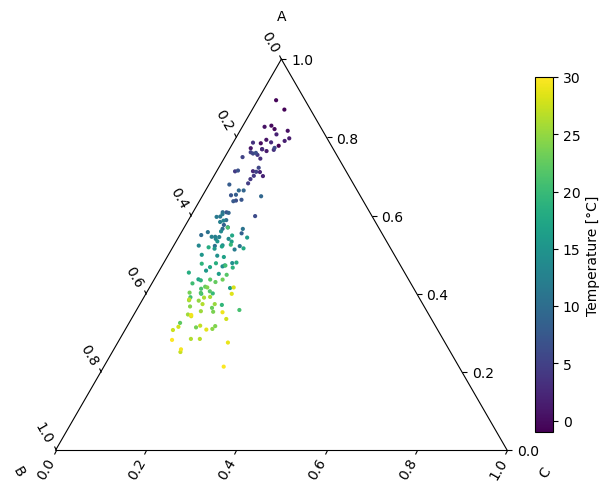

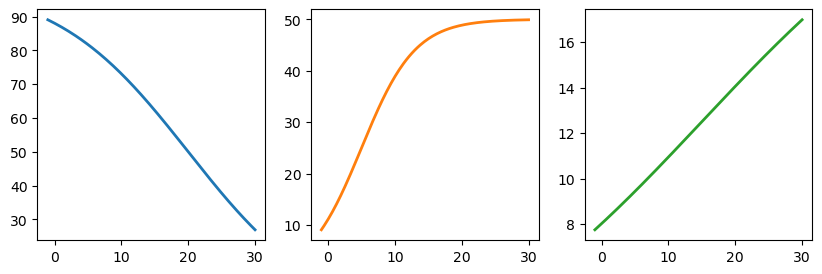

In [2]:
rng = np.random.default_rng(1234)
n_obs = 150
N = 1

def logistic_curve(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

T_hats = np.linspace(-1,30,n_obs)

T0 = np.array([20,5,15])
# T0 = np.zeros(3)+15
L = np.array([100,50,25])
K = np.array([-0.1,0.25,0.05])

data = []
for x in T_hats:
    alpha = logistic_curve(x,L,K,T0)
    data.append(rng.dirichlet(alpha=alpha, size=N))

data = np.array(data)
print(data.shape)
A = data[:,0,0]
B = data[:,0,1]
C = data[:,0,2]

fig, ax = plt.subplots(1,1,subplot_kw={"projection": "ternary"})
pc = ax.scatter(A, B, C, c=T_hats, marker='.',lw=0)
plt.colorbar(pc,ax=ax,shrink=0.9,label='Temperature [°C]')

ax.set_tlabel('A')
ax.set_llabel('B')
ax.set_rlabel('C')

fig.tight_layout()

fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)
for i in range(3):
    ax[i].plot(T_hats,logistic_curve(T_hats,L[i],K[i],T0[i]), lw=2, c=f'C{i}')

In [3]:
N_SAMPLES = 100

combined_indices = np.arange(n_obs)
compound_names = ["A", "B", "C"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y = data.squeeze()

with pm.Model(coords=coords) as model:
    # data container
    T_data = pm.Data("T_data", T_hats, dims=("obs"))
    y_data = pm.Data("y_data", y, dims=("obs","compound"))
    
    # priors
    L_ = pm.Lognormal("L", mu=2, sigma=2, dims="compound")
    print(f"{L_.eval() = }")

    K_ = pm.Normal("K", mu=0, sigma=0.1, dims="compound")
    print(f"{K_.eval() = }")

    T0_ = pm.Normal("T0", mu=15, sigma=3, dims="compound")
    print(f"{T0_.eval() = }")

    # T_sigma_ = pm.HalfNormal("T_sigma", sigma=1)
    # print(f"{T_sigma_.eval() = }")

    T_hats_mu_ = pm.Normal("T_hats_mu", mu=np.nanmean(T_hats), sigma=np.nanstd(T_hats), dims=("obs"))

    T_hats_ = pm.Normal("T_hats", mu=T_hats_mu_, sigma=1, observed=T_data, dims=("obs"))
    
    a_ = []
    for i in range(3):
        a_.append(L_[i]/(1+pm.math.exp(-K_[i]*(T_hats_-T0_[i]))))

    y_ = pm.Dirichlet("y", a=pm.math.stack(a_).T, observed=y_data, dims=("obs","compound"))
    print(f"{y_.eval().shape = }")

     # Sample from prior
    idata = pm.sample_prior_predictive(samples=N_SAMPLES)

L_.eval() = array([ 6.83087489,  1.0602371 , 75.855125  ])
K_.eval() = array([0.12666784, 0.03490554, 0.02115396])
T0_.eval() = array([13.13780166, 13.68190742, 12.56409981])


Sampling: [K, L, T0, T_hats, T_hats_mu, y]


y_.eval().shape = (150, 3)


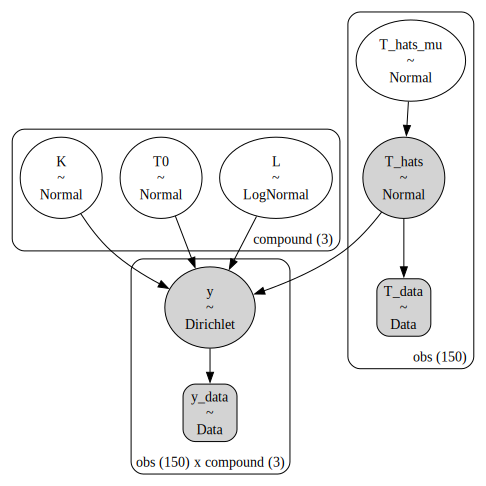

In [4]:
gv = pm.model_to_graphviz(model)
gv

In [5]:
model.free_RVs

[L ~ LogNormal(2, 2),
 K ~ Normal(0, 0.1),
 T0 ~ Normal(15, 3),
 T_hats_mu ~ Normal(14.5, 9.01)]

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)


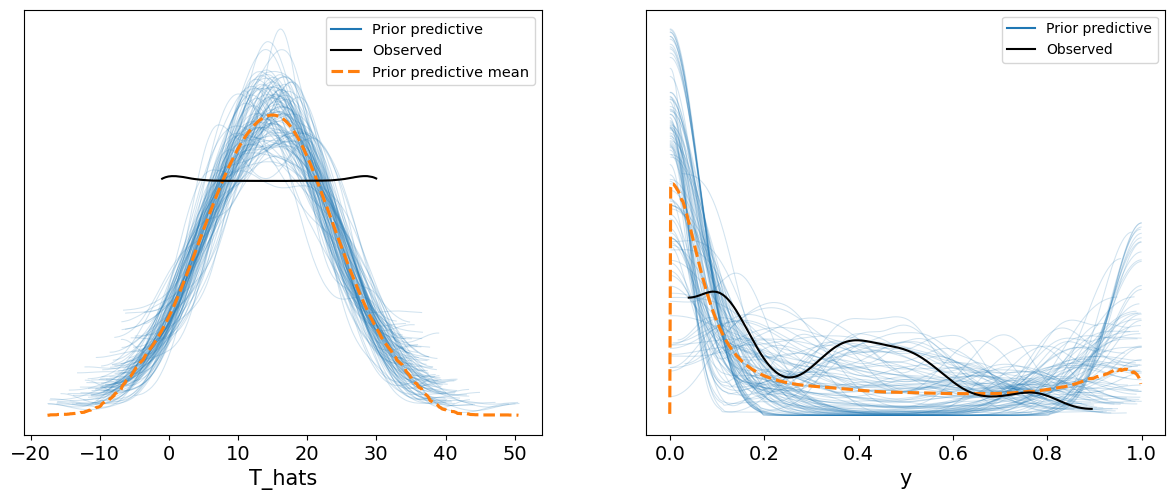

In [6]:
ax = az.plot_ppc(idata, group='prior', observed=True)

In [7]:
# posterior sampling
with model:
    idata.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, K, T0, T_hats_mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


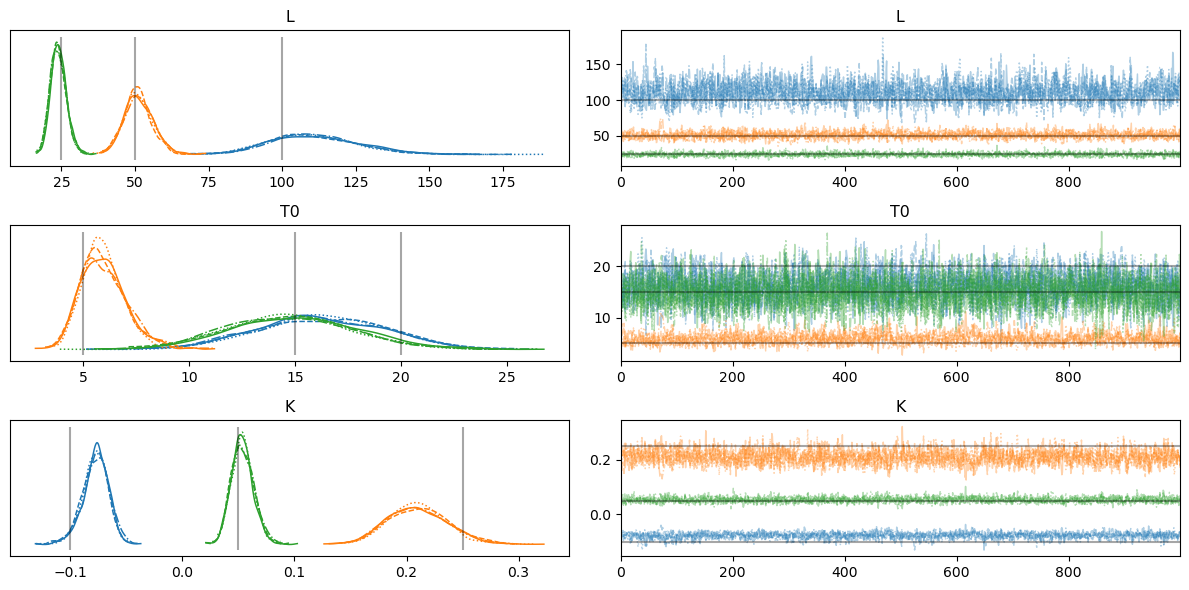

In [8]:
var_names = ["L", "T0", "K"]

lines = (
    ('L', {}, L),
    ('T0', {}, T0),
    ('K', {}, K),
)

ax = az.plot_trace(idata,var_names=var_names, lines=lines)
# ax[0,0].set_xscale("log")
# ax[0,1].set_yscale("log")
plt.tight_layout()

In [9]:
az.summary(idata,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[A],110.859,14.822,83.586,137.754,0.357,0.253,1689.0,2202.0,1.0
L[B],51.190,4.869,42.173,60.431,0.118,0.085,1762.0,2455.0,1.0
L[C],23.969,2.672,19.189,29.074,0.057,0.041,2145.0,2865.0,1.0
T0[A],16.234,2.983,10.909,21.861,0.068,0.049,1922.0,2118.0,1.0
T0[B],5.965,1.071,4.110,7.979,0.032,0.023,1267.0,1658.0,1.0
T0[C],14.813,2.972,9.166,20.258,0.052,0.037,3259.0,3075.0,1.0
K[A],-0.077,0.012,-0.100,-0.056,0.000,0.000,1710.0,2147.0,1.0
K[B],0.210,0.026,0.164,0.262,0.001,0.000,1653.0,2163.0,1.0
K[C],0.054,0.010,0.036,0.072,0.000,0.000,2147.0,2796.0,1.0


In [10]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [T_hats, y]


Output()

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)


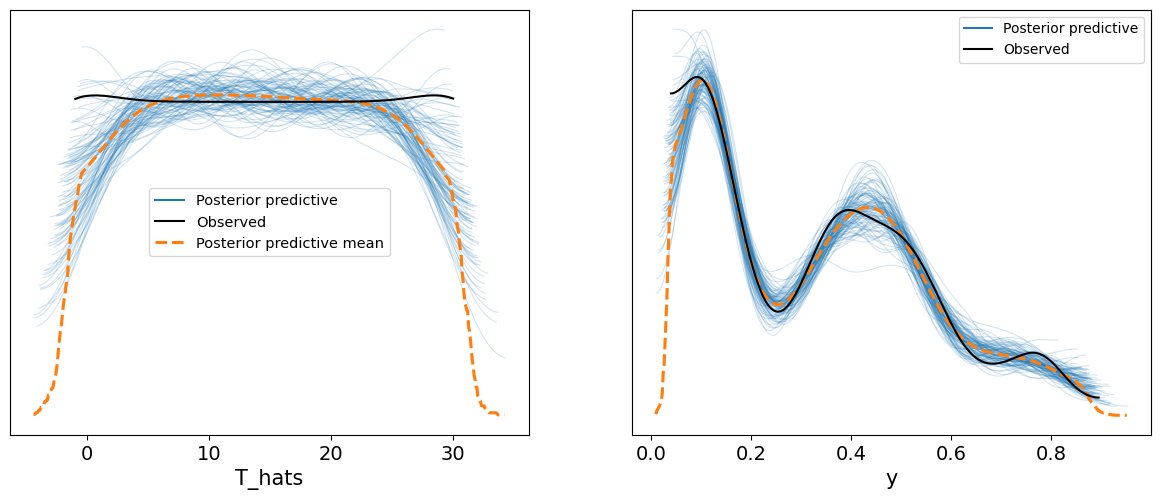

In [11]:
ax = az.plot_ppc(idata, num_pp_samples=100)

In [12]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

(150, 3)


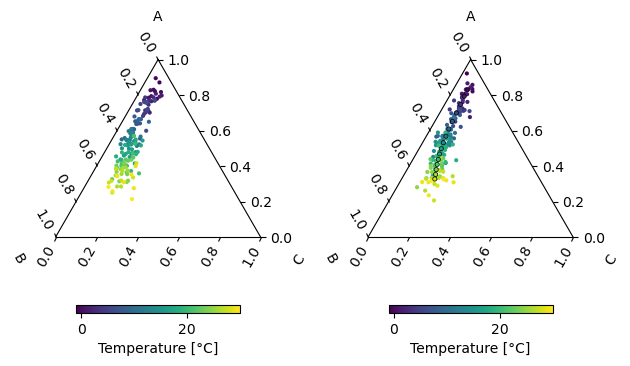

In [13]:
stacked = idata.stack(samples=("chain","draw"))
y_pred_mean = stacked.posterior_predictive["y"].mean("samples")
T_pred_mean = stacked.posterior["T_hats_mu"].mean("samples")
y_pred = stacked.posterior_predictive["y"].isel(samples=0)
T_pred = stacked.posterior["T_hats_mu"].isel(samples=0)
print(y_pred.shape)

fig, ax = plt.subplots(1,2,subplot_kw={"projection": "ternary"})

pc = ax[0].scatter(A, B, C, c=T_hats, vmin=min(T_hats), vmax=max(T_hats), marker='.', lw=0)
pc = ax[1].scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], c=T_pred, vmin=min(T_hats), vmax=max(T_hats), marker='.',lw=0)
inc = 10
ax[1].scatter(y_pred_mean[::inc,0], y_pred_mean[::inc,1], y_pred_mean[::inc,2], c=T_pred_mean[::inc], vmin=min(T_hats), vmax=max(T_hats), marker='.',lw=0.5, edgecolors='k')

for a in ax:
    plt.colorbar(pc,ax=a,orientation="horizontal", shrink=0.8,label='Temperature [°C]')
    a.set_tlabel('A')
    a.set_llabel('B')
    a.set_rlabel('C')

fig.tight_layout()

In [14]:
with model:
    pm.compute_log_likelihood(idata)

Output()

<Axes: xlabel='T_hats'>

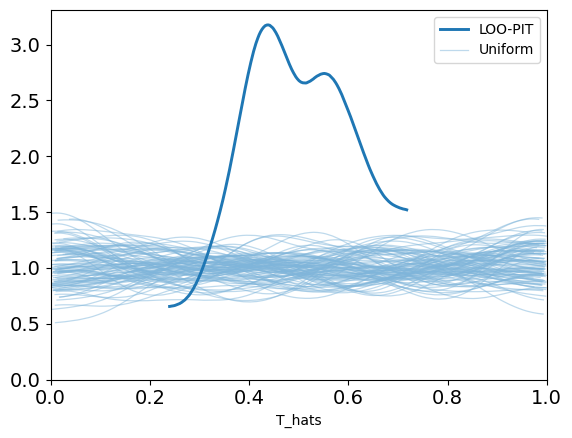

In [15]:
az.plot_loo_pit(idata, "T_hats")